In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from typing import Tuple, List
import numpy as np
from keras.datasets import mnist
import torchvision.transforms as transforms

class LeNet5(nn.Module):
    def __init__(self, num_classes: int = 10):
        """
        Initialize the LeNet-5 architecture.

        Parameters:
            num_classes (int): Number of output classes
        """
        super(LeNet5, self).__init__()

        # Convolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(16 * 5 * 5, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, num_classes)
        )

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        """Initialize network weights using Xavier initialization."""
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Perform the forward pass through the network.

        Parameters:
            x (torch.Tensor): Input image batch of shape (batch_size, 1, height, width)

        Returns:
            torch.Tensor: Output predictions of shape (batch_size, num_classes)
        """

        # Convolutional layers
        x = self.conv_layers(x)

        # Flatten the output for the fully connected layers
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = self.fc_layers(x)

        return x

    def train_model(self,
                    train_loader: DataLoader,
                    test_loader: DataLoader,  # Thêm test_loader để đánh giá sau mỗi epoch
                    num_epochs: int,
                    learning_rate: float,
                    device: torch.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
        """
        Train the LeNet-5 model and log metrics.
        """
        self.to(device)

        # Define loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.parameters(), lr=learning_rate)

        # Initialize lists to store metrics
        train_losses = []
        train_accuracies = []
        test_accuracies = []

        # Training loop
        for epoch in range(num_epochs):
            self.train()  # Set model to training mode
            running_loss = 0.0
            correct = 0
            total = 0

            # Training phase
            for i, (inputs, labels) in enumerate(train_loader):
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = self(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                # Calculate accuracy
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                running_loss += loss.item()

                if i % 500 == 499:
                    print(f'[Epoch {epoch + 1}, Batch {i + 1}] Loss: {running_loss/100:.4f}')
                    running_loss = 0.0

            # Calculate epoch metrics
            epoch_loss = running_loss / len(train_loader)
            epoch_accuracy = 100 * correct / total

            # Evaluate on test set
            test_accuracy = self.evaluate(test_loader, device)

            # Store metrics
            train_losses.append(epoch_loss)
            train_accuracies.append(epoch_accuracy)
            test_accuracies.append(test_accuracy)

            # Print epoch summary
            print(f'Epoch {epoch + 1}/{num_epochs}:')
            print(f'Training Loss: {epoch_loss:.4f}')
            print(f'Training Accuracy: {epoch_accuracy:.2f}%')
            print(f'Test Accuracy: {test_accuracy:.2f}%')
            print('-' * 60)

        # Return training history
        history = {
            'train_loss': train_losses,
            'train_acc': train_accuracies,
            'test_acc': test_accuracies
        }

        return history

    def predict(self,
                test_loader: DataLoader,
                device: torch.device) -> np.ndarray:
        """
        Make predictions using GPU if available.
        """
        self.eval()  # Set to evaluation mode
        predictions = []

        with torch.no_grad():
            for inputs, _ in test_loader:
                inputs = inputs.to(device)  # Chuyển input sang device
                outputs = self(inputs)
                _, predicted = torch.max(outputs.data, 1)
                predictions.extend(predicted.cpu().numpy())  # Chuyển kết quả về CPU trước khi chuyển sang numpy

        return np.array(predictions)
    def evaluate(self,
                test_loader: DataLoader,
                device: torch.device) -> float:
        """
        Evaluate model accuracy using GPU if available.
        """
        self.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = self(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f'Accuracy on test set: {accuracy:.2f}%')
        return accuracy
def plot_training_history(history):
    import matplotlib.pyplot as plt

    # Plot training loss
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'])
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train')
    plt.plot(history['test_acc'], label='Test')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [15]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Initialize model and move to GPU
model = LeNet5(num_classes=10)
model = model.to(device)

# Prepare data
def prepare_data(X: np.ndarray, y: np.ndarray, batch_size: int, augment: bool = False) -> DataLoader:
    # normalize data
    X = X.astype(np.float32)

    if len(X.shape) == 3:
        X = X.reshape(-1, 1, X.shape[1], X.shape[2])

    transform_list = []

    if augment:
        transform_list.extend([
            transforms.RandomRotation(10),        # Xoay ảnh trong khoảng [-10, 10] độ
            transforms.RandomAffine(0, translate=(0.1, 0.1)),  # Dịch ngang/dọc tối đa 10%
            transforms.RandomResizedCrop(28, scale=(0.9, 1.1))  # Zoom ngẫu nhiên [-10%, +10%]
        ])

    transform_list.extend([
        transforms.ToTensor(),          # Chuyển ảnh thành tensor
        transforms.Normalize((0.5,), (0.5,))  # Chuẩn hóa ảnh về khoảng [-1,1]
    ])

    transform = transforms.Compose(transform_list)

    # convert to tensor
    X_tensor = torch.FloatTensor(X)
    y_tensor = torch.LongTensor(y)

    # create dataset
    dataset = TensorDataset(X_tensor, y_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    return dataloader

# Prepare data loaders
train_loader = prepare_data(X_train, y_train, batch_size=32)
test_loader = prepare_data(X_test, y_test, batch_size=32)

# Train model with GPU
history = model.train_model(
    train_loader=train_loader,
    test_loader=test_loader,
    num_epochs=10,
    learning_rate=0.001,
    device=device
)

Using device: cuda
[Epoch 1, Batch 500] Loss: 5.2762
[Epoch 1, Batch 1000] Loss: 0.8741
[Epoch 1, Batch 1500] Loss: 0.6772
Accuracy on test set: 97.21%
Epoch 1/10:
Training Loss: 0.0218
Training Accuracy: 92.44%
Test Accuracy: 97.21%
------------------------------------------------------------
[Epoch 2, Batch 500] Loss: 0.4183
[Epoch 2, Batch 1000] Loss: 0.4278
[Epoch 2, Batch 1500] Loss: 0.3923
Accuracy on test set: 97.77%
Epoch 2/10:
Training Loss: 0.0170
Training Accuracy: 97.52%
Test Accuracy: 97.77%
------------------------------------------------------------
[Epoch 3, Batch 500] Loss: 0.2818
[Epoch 3, Batch 1000] Loss: 0.3174
[Epoch 3, Batch 1500] Loss: 0.3094
Accuracy on test set: 98.14%
Epoch 3/10:
Training Loss: 0.0125
Training Accuracy: 98.09%
Test Accuracy: 98.14%
------------------------------------------------------------
[Epoch 4, Batch 500] Loss: 0.2386
[Epoch 4, Batch 1000] Loss: 0.2740
[Epoch 4, Batch 1500] Loss: 0.2827
Accuracy on test set: 98.60%
Epoch 4/10:
Training

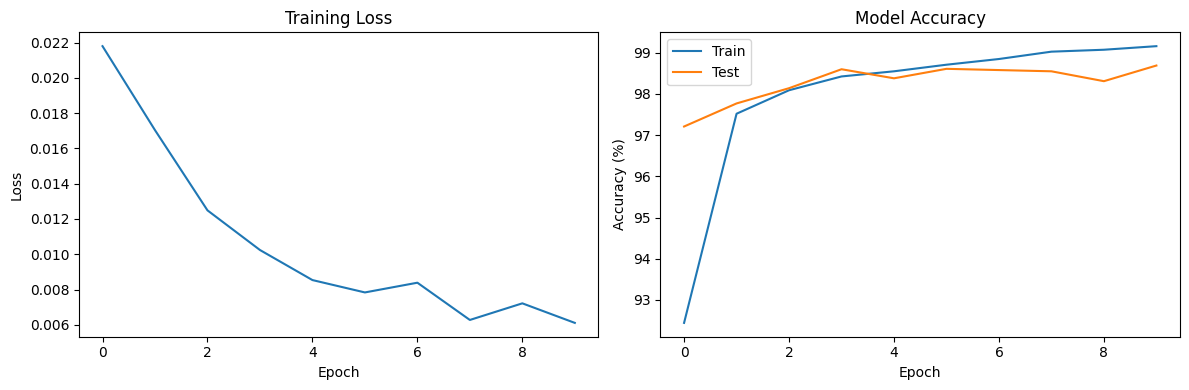

In [17]:
plot_training_history(history)

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Initialize model and move to GPU
model = LeNet5(num_classes=10)
model = model.to(device)

# Prepare data
def prepare_data(X: np.ndarray, y: np.ndarray, batch_size: int, augment: bool = False) -> DataLoader:
    # normalize data
    X = X.astype(np.float32)

    if len(X.shape) == 3:
        X = X.reshape(-1, 1, X.shape[1], X.shape[2])

    transform_list = []

    if augment:
        transform_list.extend([
            transforms.RandomRotation(10),        # Xoay ảnh trong khoảng [-10, 10] độ
            transforms.RandomAffine(0, translate=(0.1, 0.1)),  # Dịch ngang/dọc tối đa 10%
            transforms.RandomResizedCrop(28, scale=(0.9, 1.1))  # Zoom ngẫu nhiên [-10%, +10%]
        ])

    transform_list.extend([
        transforms.ToTensor(),          # Chuyển ảnh thành tensor
        transforms.Normalize((0.5,), (0.5,))  # Chuẩn hóa ảnh về khoảng [-1,1]
    ])

    transform = transforms.Compose(transform_list)

    # convert to tensor
    X_tensor = torch.FloatTensor(X)
    y_tensor = torch.LongTensor(y)

    # create dataset
    dataset = TensorDataset(X_tensor, y_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    return dataloader

# Prepare data loaders
train_loader = prepare_data(X_train, y_train, batch_size=32, augment = True)
test_loader = prepare_data(X_test, y_test, batch_size=32)

# Train model with GPU
history_augment = model.train_model(
    train_loader=train_loader,
    test_loader=test_loader,
    num_epochs=10,
    learning_rate=0.001,
    device=device
)

Using device: cuda
[Epoch 1, Batch 500] Loss: 4.6927
[Epoch 1, Batch 1000] Loss: 1.0134
[Epoch 1, Batch 1500] Loss: 0.7184
Accuracy on test set: 96.60%
Epoch 1/10:
Training Loss: 0.0245
Training Accuracy: 92.29%
Test Accuracy: 96.60%
------------------------------------------------------------
[Epoch 2, Batch 500] Loss: 0.4720
[Epoch 2, Batch 1000] Loss: 0.4277
[Epoch 2, Batch 1500] Loss: 0.4521
Accuracy on test set: 97.70%
Epoch 2/10:
Training Loss: 0.0153
Training Accuracy: 97.35%
Test Accuracy: 97.70%
------------------------------------------------------------
[Epoch 3, Batch 500] Loss: 0.3532
[Epoch 3, Batch 1000] Loss: 0.3504
[Epoch 3, Batch 1500] Loss: 0.2956
Accuracy on test set: 97.59%
Epoch 3/10:
Training Loss: 0.0136
Training Accuracy: 97.97%
Test Accuracy: 97.59%
------------------------------------------------------------
[Epoch 4, Batch 500] Loss: 0.2468
[Epoch 4, Batch 1000] Loss: 0.2749
[Epoch 4, Batch 1500] Loss: 0.3024
Accuracy on test set: 98.45%
Epoch 4/10:
Training

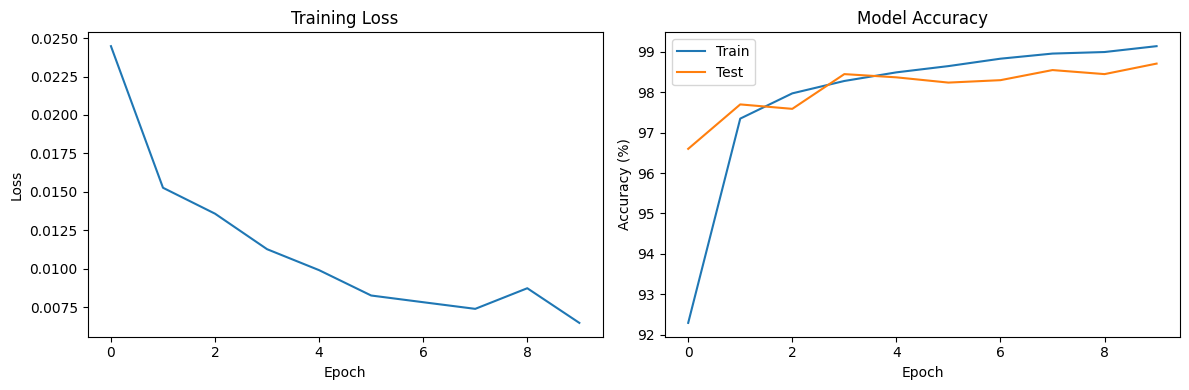

In [20]:
plot_training_history(history_augment)